# PROJECT - SEMESTER 7

## CREATION OF DATASET (Temporary)

In [1]:
# importing libraries
import pandas as pd
import numpy as np

In [2]:
# Creating dictionary of Data
data = dict()
data['temp']=[10,20,30,40,50]
data['vib']=[100,200,300,400,500]
data['speed']=[40,80,140,150,16]
data['current']=[30,50,60,70,80]
data['voltage']=[5,20,31,32,120]
data['output']=[1,0,1,1,0]

In [6]:
data = pd.DataFrame(data)

In [7]:
# Description of data
data.describe()

,temp,vib,speed,current,voltage,output
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,30.000000,300.000000,85.200000,58.000000,41.600000,0.600000
std,15.811388,158.113883,59.289122,19.235384,45.158609,0.547723
min,10.000000,100.000000,16.000000,30.000000,5.000000,0.000000
25%,20.000000,200.000000,40.000000,50.000000,20.000000,0.000000
50%,30.000000,300.000000,80.000000,60.000000,31.000000,1.000000
75%,40.000000,400.000000,140.000000,70.000000,32.000000,1.000000
max,50.000000,500.000000,150.000000,80.000000,120.000000,1.000000


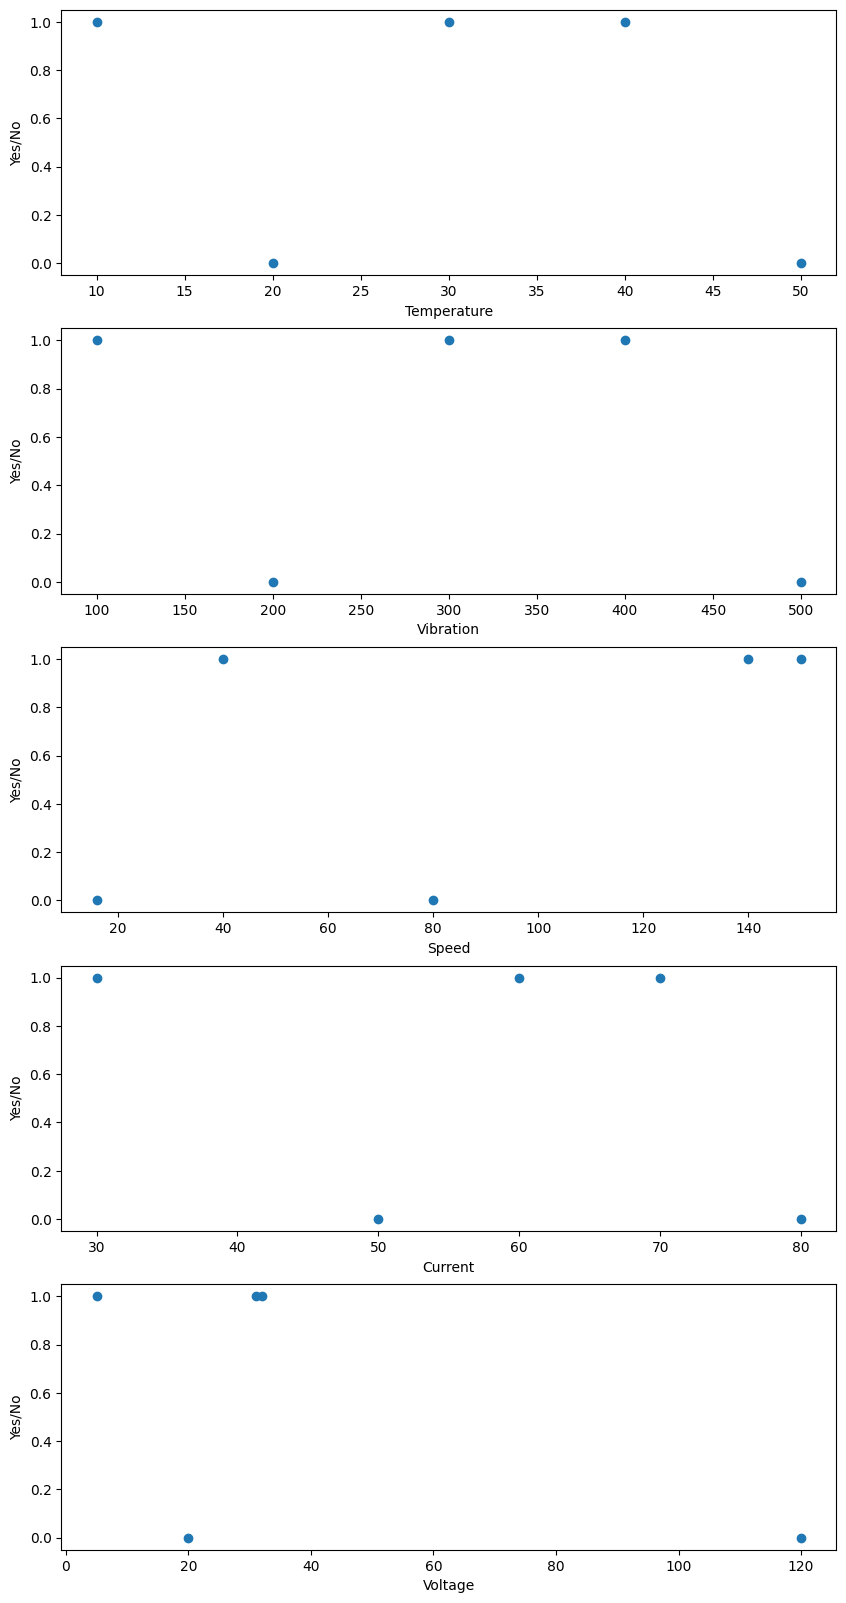

In [13]:
# Initial visualizations on data
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, figsize=(10,20))
ax[0].scatter(x = data['temp'], y=data['output'])
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("Yes/No")

ax[1].scatter(x = data['vib'], y=data['output'])
ax[1].set_xlabel("Vibration")
ax[1].set_ylabel("Yes/No")

ax[2].scatter(x = data['speed'], y=data['output'])
ax[2].set_xlabel("Speed")
ax[2].set_ylabel("Yes/No")

ax[3].scatter(x = data['current'], y=data['output'])
ax[3].set_xlabel("Current")
ax[3].set_ylabel("Yes/No")

ax[4].scatter(x = data['voltage'], y=data['output'])
ax[4].set_xlabel("Voltage")
ax[4].set_ylabel("Yes/No")


plt.show()

## GENERATION OF SYNTHETIC DATA
&copy; Research Teams at Indian Institute of Science, Education and Research Tiruvananthapuram. All rights reserved. Any attempt to copy this work infringes with the rights.

In [15]:
# Initial inspections for
no_f=data['output'].value_counts()[0]/len(data)*100
f=data['output'].value_counts()[1]/len(data)*100
print("No error=",no_f,"\nError =",f)

No error= 40.0 
Error = 60.0


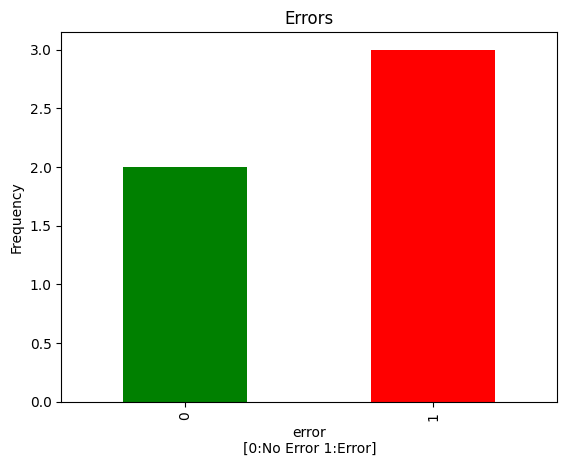

In [16]:
# Plotting frequency on bar graph
import matplotlib.pyplot as plt
%matplotlib inline

count_classes = pd.value_counts(data['output'], sort = True).sort_index()
count_classes.plot(kind = 'bar',color=['green','red'])
plt.title("Errors")
plt.xlabel("Error\n[0:No Error 1:Error]")
plt.ylabel("Frequency")
plt.show()

In [20]:
# seperating classes with two labels
data_1=data[data.output==1]
data_0=data[data.output==0]

### For class 0

In [34]:
# importing needed libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler


In [36]:
# creating float Tensor for our dataset
class ErrorDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index]


In [37]:
# defining the TVAE model architecture
class TVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(TVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # The last layer outputs mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output is scaled between 0 and 1
        )
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent_stats = self.encoder(x)
        mu, logvar = torch.chunk(latent_stats, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [38]:
# training function
def working(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs in dataloader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(reconstructed, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [39]:
 # loss function
def tvae_loss(reconstructed, inputs, mu, logvar):
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, inputs)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence


In [40]:
# manuel seeding
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [56]:
# function to call the model and train it
def train_model(df):
  # spliting the dataset into features and labels
  features = df.drop("output", axis=1).values
  labels = df["output"].values

    # performing feature scaling on the features
  scaler = StandardScaler()
  features = scaler.fit_transform(features)
    # creating the dataset

  dataset = ErrorDataset(features)

  # creating a data loader for the dataset
  batch_size = 64
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # initializing the TVAE model
  input_dim = features.shape[1]
  hidden_dim = 256
  latent_dim = 10
  tvae_model = TVAE(input_dim, hidden_dim, latent_dim).to(device)


  lr = 0.001
  num_epochs = 200
  weight_decay = 1e-5


  optimizer = optim.Adam(tvae_model.parameters(), lr=lr,weight_decay=weight_decay)
  criterion = tvae_loss

  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")
      epoch_loss = working(tvae_model, dataloader, optimizer, criterion, device)
      print(f"Loss: {epoch_loss:.4f}")


In [57]:
# function for synthetic data generator
def generator(input_dim,no):
  num_samples = no
  latent_dim = 10
  tvae_model = TVAE(input_dim, 256, latent_dim).to(device)
  latent_samples = torch.randn(num_samples, latent_dim).to(device)
  synthetic_data = tvae_model.decoder(latent_samples).detach().cpu()
  return synthetic_data


### For class 0

In [75]:
# fet and labels
features = data_0.drop('output', axis=1).values
labels = data_0['output'].values

In [76]:
# training and generation
train_model(data_0)

Epoch 1/200
Loss: 8.4807
Epoch 2/200
Loss: 5.7490
Epoch 3/200
Loss: 6.4900
Epoch 4/200
Loss: 6.1348
Epoch 5/200
Loss: 6.5024
Epoch 6/200
Loss: 6.4230
Epoch 7/200
Loss: 6.6279
Epoch 8/200
Loss: 5.4831
Epoch 9/200
Loss: 4.0381
Epoch 10/200
Loss: 3.7753
Epoch 11/200
Loss: 4.2484
Epoch 12/200
Loss: 4.9311
Epoch 13/200
Loss: 6.4382
Epoch 14/200
Loss: 6.1608
Epoch 15/200
Loss: 3.0585
Epoch 16/200
Loss: 3.9575
Epoch 17/200
Loss: 2.3223
Epoch 18/200
Loss: 2.5744
Epoch 19/200
Loss: 6.8236
Epoch 20/200
Loss: 4.6837
Epoch 21/200
Loss: -1.0629
Epoch 22/200
Loss: 2.6196
Epoch 23/200
Loss: -0.0346
Epoch 24/200
Loss: 6.2373
Epoch 25/200
Loss: 7.4150
Epoch 26/200
Loss: -2.1825
Epoch 27/200
Loss: 5.1765
Epoch 28/200
Loss: 2.9473
Epoch 29/200
Loss: 0.1049
Epoch 30/200
Loss: 2.6405
Epoch 31/200
Loss: 0.2156
Epoch 32/200
Loss: -1.0171
Epoch 33/200
Loss: 5.1102
Epoch 34/200
Loss: 1.9688
Epoch 35/200
Loss: 1.6335
Epoch 36/200
Loss: 2.5562
Epoch 37/200
Loss: -4.1846
Epoch 38/200
Loss: -3.5839
Epoch 39/200
Lo

In [77]:
# generation of samples
no = 1000
samples=generator(features.shape[1],no)

 # balancing

arr=samples.numpy()
samples=pd.DataFrame(arr)
samples['output']=[0]*no
samples.columns=['temp', 	'vib', 	'speed', 	'current', 	'voltage', 	'output']
new_data_0=pd.concat([data_0,samples])
new_data_0=new_data_0.sample(frac=1)

In [78]:
new_data_0

,temp,vib,speed,current,voltage,output
610,0.555293,0.537659,0.447738,0.532607,0.510348,0
466,0.547794,0.504349,0.442759,0.495114,0.470870,0
353,0.517551,0.417265,0.486186,0.474203,0.605689,0
584,0.535910,0.407336,0.517947,0.524843,0.522660,0
937,0.551744,0.528801,0.414925,0.459205,0.534197,0
...,...,...,...,...,...,...
684,0.551142,0.468514,0.527296,0.451344,0.557779,0
930,0.506420,0.501834,0.480860,0.461940,0.567292,0
104,0.540057,0.499036,0.458938,0.549405,0.562641,0
118,0.505918,0.541213,0.580928,0.440450,0.566184,0


### For class 1

In [81]:
# fet and labels
features = data_1.drop('output', axis=1).values
labels = data_1['output'].values

In [80]:
# training and generation
train_model(data_1)

Epoch 1/200
Loss: 13.4274
Epoch 2/200
Loss: 14.2800
Epoch 3/200
Loss: 10.9540
Epoch 4/200
Loss: 10.5224
Epoch 5/200
Loss: 10.6081
Epoch 6/200
Loss: 10.9422
Epoch 7/200
Loss: 8.1326
Epoch 8/200
Loss: 8.5908
Epoch 9/200
Loss: 7.8714
Epoch 10/200
Loss: 8.3560
Epoch 11/200
Loss: 6.0222
Epoch 12/200
Loss: 7.1067
Epoch 13/200
Loss: 5.0273
Epoch 14/200
Loss: 8.7935
Epoch 15/200
Loss: 3.6806
Epoch 16/200
Loss: 5.0190
Epoch 17/200
Loss: 8.2583
Epoch 18/200
Loss: 9.3104
Epoch 19/200
Loss: 7.2882
Epoch 20/200
Loss: 7.7268
Epoch 21/200
Loss: 1.9141
Epoch 22/200
Loss: 2.9532
Epoch 23/200
Loss: -0.4611
Epoch 24/200
Loss: 2.5285
Epoch 25/200
Loss: 9.7366
Epoch 26/200
Loss: -0.6358
Epoch 27/200
Loss: -6.0239
Epoch 28/200
Loss: 5.3463
Epoch 29/200
Loss: 3.4207
Epoch 30/200
Loss: -3.2043
Epoch 31/200
Loss: -2.9439
Epoch 32/200
Loss: -2.6854
Epoch 33/200
Loss: -11.5853
Epoch 34/200
Loss: -6.2017
Epoch 35/200
Loss: 0.0241
Epoch 36/200
Loss: -3.2660
Epoch 37/200
Loss: -5.4604
Epoch 38/200
Loss: -4.9233
Epo

In [82]:
# generation of samples
no = 1000
samples=generator(features.shape[1],no)

 # balancing

arr=samples.numpy()
samples=pd.DataFrame(arr)
samples['output']=[1]*no
samples.columns=['temp', 	'vib', 	'speed', 	'current', 	'voltage', 	'output']
new_data_1=pd.concat([data_0,samples])
new_data_1=new_data_1.sample(frac=1)

### Combining the classes and visuals

In [83]:
data_final = pd.concat([new_data_0,new_data_1])
data_final=data_final.sample(frac=1)

In [84]:
data_final

,temp,vib,speed,current,voltage,output
945,0.296324,0.450438,0.452123,0.566115,0.311395,1
115,0.482456,0.415015,0.569623,0.492946,0.568975,0
630,0.481499,0.446716,0.459466,0.498630,0.462809,0
155,0.504440,0.453389,0.531565,0.443434,0.619666,0
535,0.468223,0.532230,0.445438,0.476240,0.412927,1
...,...,...,...,...,...,...
371,0.543414,0.524334,0.422732,0.444661,0.503802,0
76,0.500367,0.477631,0.494692,0.527307,0.547360,0
327,0.284620,0.491976,0.428577,0.569844,0.479261,1
223,0.376432,0.584720,0.410228,0.515384,0.327284,1


In [86]:
data_final.describe()

,temp,vib,speed,current,voltage,output
count,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000
mean,0.537052,1.198206,0.575431,0.647897,0.657304,0.499002
std,1.682142,16.981859,2.559174,2.956184,3.823405,0.500124
min,0.284620,0.247089,0.318539,0.344275,0.310822,0.000000
25%,0.423205,0.458106,0.433103,0.479705,0.470287,0.000000
50%,0.469463,0.503920,0.469463,0.521400,0.516566,0.000000
75%,0.514267,0.545616,0.523674,0.560255,0.566053,1.000000
max,50.000000,500.000000,80.000000,80.000000,120.000000,1.000000


In [87]:
data.describe()

,temp,vib,speed,current,voltage,output
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,30.000000,300.000000,85.200000,58.000000,41.600000,0.600000
std,15.811388,158.113883,59.289122,19.235384,45.158609,0.547723
min,10.000000,100.000000,16.000000,30.000000,5.000000,0.000000
25%,20.000000,200.000000,40.000000,50.000000,20.000000,0.000000
50%,30.000000,300.000000,80.000000,60.000000,31.000000,1.000000
75%,40.000000,400.000000,140.000000,70.000000,32.000000,1.000000
max,50.000000,500.000000,150.000000,80.000000,120.000000,1.000000


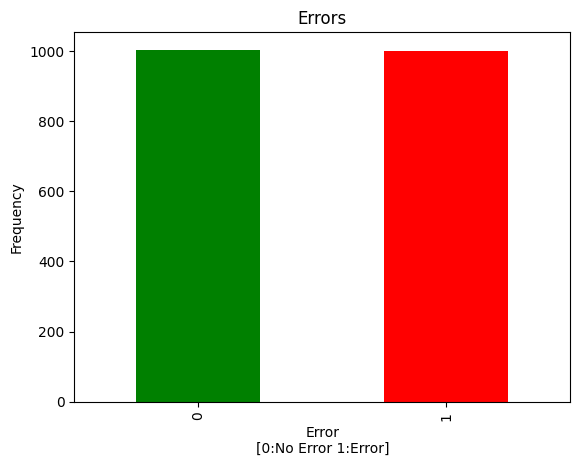

In [88]:
# Plotting frequency on bar graph
import matplotlib.pyplot as plt
%matplotlib inline

count_classes = pd.value_counts(data_final['output'], sort = True).sort_index()
count_classes.plot(kind = 'bar',color=['green','red'])
plt.title("Errors")
plt.xlabel("Error\n[0:No Error 1:Error]")
plt.ylabel("Frequency")
plt.show()

### Visualizing the efficiency


In [90]:
# Splitting into train and test in 4:1
from sklearn.model_selection import train_test_split
train, test=train_test_split(data_final,test_size=0.20,random_state=1)

In [91]:
# split train data into features and labels
x = train.drop('output', axis=1).values.astype(float)
y = train['output'].values.astype(float)

In [92]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [93]:
# Creating 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [94]:
# Calling the classifier with 10 branches
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

In [95]:
# Performing cross-validation
scores = cross_val_score(rf_classifier, x, y, cv=kfold)

In [96]:
# Printing accuracy per fold
for fold, score in enumerate(scores, 1):
    print("Fold",fold,':', "Accuracy =", score)
print("Mean Accuracy:", scores.mean())

Fold 1 : Accuracy = 0.9565217391304348
Fold 2 : Accuracy = 0.9503105590062112
Fold 3 : Accuracy = 0.9627329192546584
Fold 4 : Accuracy = 0.95625
Fold 5 : Accuracy = 0.95625
Fold 6 : Accuracy = 0.9625
Fold 7 : Accuracy = 0.9625
Fold 8 : Accuracy = 0.95625
Fold 9 : Accuracy = 0.95625
Fold 10 : Accuracy = 0.95625
Mean Accuracy: 0.9575815217391306


In [97]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, cohen_kappa_score, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, make_scorer

In [98]:
# Define the evaluation metrics
scoring = {
    'F1-Score': make_scorer(f1_score, average='macro'),
    'Kappa-Score': make_scorer(cohen_kappa_score),
    'Average Precision Score': make_scorer(average_precision_score),
    'G-Mean': make_scorer(lambda y_true, y_pred: np.sqrt(accuracy_score(y_true, y_pred) * recall_score(y_true, y_pred, average='macro')), greater_is_better=True),
    'Accuracy': make_scorer(accuracy_score)
}

In [99]:
# Perform cross-validation and calculate evaluation metrics
scores = cross_validate(rf_classifier, x, y, cv=kfold, scoring=scoring)

In [100]:
# Print the evaluation metrics for each fold and the mean values
for metric in scores.keys():
    fold_scores = scores[metric]
    print(metric,':', fold_scores,'\n')
    print("Mean",metric,':', fold_scores.mean(),"\n")

fit_time : [0.13651347 0.05827546 0.05634594 0.08963037 0.08590674 0.1173048
 0.13597465 0.11507869 0.12690377 0.09457088] 

Mean fit_time : 0.10165047645568848 

score_time : [0.01981163 0.01749659 0.02467442 0.02630377 0.0206306  0.03816175
 0.0165081  0.02968884 0.021209   0.02827191] 

Mean score_time : 0.024275660514831543 

test_F1-Score : [0.95641412 0.95030864 0.96220657 0.95604223 0.95624829 0.96235294
 0.96247655 0.95575046 0.95586207 0.95586207] 

Mean test_F1-Score : 0.9573523951560796 

test_Kappa-Score : [0.91285858 0.90063262 0.92442497 0.91211551 0.91258195 0.92471769
 0.92496483 0.91153239 0.91175544 0.91181102] 

Mean test_Kappa-Score : 0.9147394993812581 

test_Average Precision Score : [0.94199607 0.92244452 0.94230504 0.92111572 0.95331711 0.94676387
 0.95330582 0.95398308 0.93741673 0.94435714] 

Mean test_Average Precision Score : 0.9417005093350188 

test_G-Mean : [0.95621108 0.95034818 0.9618592  0.95690764 0.9568058  0.96213966
 0.96270828 0.95709288 0.9554187

## MODEL 1 - BINARY CLASSIFIER

In [101]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [106]:
# Splitting the data into training and testing sets
train,test = train_test_split(data_final, test_size=0.2, random_state=42)

In [107]:
# Building the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

In [108]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                192       
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [121]:
# Eval metrics
# Custom callback to collect training speed and convergence per epoch
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import time
class TrainingStatsCallback(Callback):
    def __init__(self):
        self.start_time = 0
        self.steps = 0
        self.speeds = []
        self.convergences = []

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        self.steps += 1

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            epoch_time = time.time() - self.start_time
            speed = epoch_time / self.steps
            self.speeds.append(speed)
            self.convergences.append(logs.get('loss'))
            self.steps = 0

In [122]:
x_train = train.drop('output', axis=1)
y_train = train['output']
x_test = test.drop('output', axis=1)
y_test = test['output']

In [123]:

# Define the model checkpoint
checkpoint = ModelCheckpoint('model.h5', monitor='loss', verbose=0, save_best_only=True, mode='min')

# Define the training stats callback
stats_callback = TrainingStatsCallback()

# Training the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[checkpoint, stats_callback])

Epoch 1/100
46/46 [==============================] - 0s 6ms/step - loss: 0.1366 - accuracy: 0.9598 - val_loss: 0.1181 - val_accuracy: 0.9627
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.1358 - accuracy: 0.9563 - val_loss: 0.1212 - val_accuracy: 0.9689
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1351 - accuracy: 0.9584 - val_loss: 0.1146 - val_accuracy: 0.9689
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1344 - accuracy: 0.9584 - val_loss: 0.1181 - val_accuracy: 0.9689
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1336 - accuracy: 0.9626 - val_loss: 0.1122 - val_accuracy: 0.9689
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1329 - accuracy: 0.9563 - val_loss: 0.1157 - val_accuracy: 0.9689
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.1325 - accuracy: 0.9563 - val_loss: 0.1141 - val_accuracy: 0.9627
Epoch 8/100
4

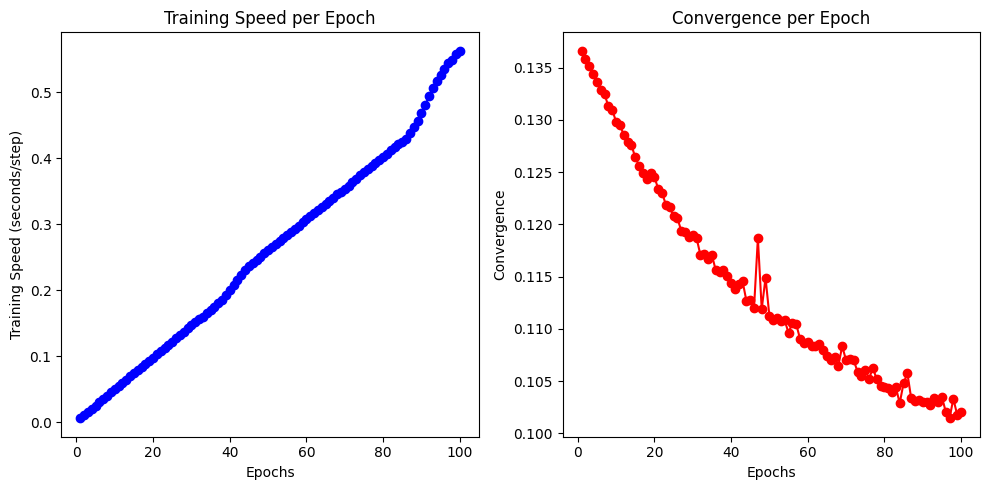

In [124]:
# Training efficiency
# Plot the training speed and convergence per epoch
epochs = range(1, len(stats_callback.speeds) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, stats_callback.speeds, 'b-o')
plt.xlabel('Epochs')
plt.ylabel('Training Speed (seconds/step)')
plt.title('Training Speed per Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs, stats_callback.convergences, 'r-o')
plt.xlabel('Epochs')
plt.ylabel('Convergence')
plt.title('Convergence per Epoch')

plt.tight_layout()
plt.show()

In [125]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

13/13 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9726
Test loss: 0.0812
Test accuracy: 0.9726


In [129]:
# prediction
new_features = 5
x_new = np.random.randn(1, num_features)  # Replace this with your actual new input
prediction = model.predict(x_new)
predicted_class = (prediction > 0.5).astype(int)

print("Predicted Probability:", prediction[0][0])
print("Predicted Class:", predicted_class[0][0])

1/1 [==============================] - 0s 31ms/step
Predicted Probability: 0.9322389
Predicted Class: 1
